# I'm making a new notebook for investigating the fraction of galaxies with photoz versus specz in the data

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# read in the data
data_pth = '/Users/astro/Desktop/GitHub/satellite_fraction/data/'
data_file = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'

hdu1 = fits.open(data_file)
pdr_data= Table(hdu1[1].data)
pdr_data[0]

object_id,ra,dec,z_spec,z_best,z_phot,z_type,gcmodel_mag,gcmodel_mag_err,rcmodel_mag,rcmodel_mag_err,icmodel_mag,icmodel_mag_err,zcmodel_mag,zcmodel_mag_err,ycmodel_mag,ycmodel_mag_err,MSTAR,logm_10,logm_30,logm_100,logm_max,vdisp_sdss,vdisp_err_sdss,logms_gama,logms_err_gama,id_cluster_redm,p_mem_redm,z_lambda_redm,lambda_redm,p_cen_1_redm,id_camira,z_camira,n_cor_camira,logms_camira,r50_max,r50_100,logmh_peak,logmh_vir,logmh_host,ra_pdr,dec_pdr,sep_arcsec_pdr
int64,float64,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
41584100993172458,339.30221049833926,-0.5047939798739985,0.25033000111579895,0.25033000111579895,nan,1,19.598822,0.0011392573,18.23641,0.0005367848,17.667036,0.00047776435,17.3642,0.0005285235,17.17294,0.0007222131,11.41357421875,11.288285695874468,11.449909889861537,11.512434451810856,11.515238377804888,239.67552185058594,19.472776412963867,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,6.954138891157053,6.867189000762649,12.736635497686821,12.736635497686821,12.736635497686821,339.30221049833926,-0.5047939798740074,3.2203116149818104e-11


In [3]:
# constrain by total stellar mass
pdr_mass_cut = Table(names = pdr_data.colnames)
for i in range(len(pdr_data)):
    if pdr_data['logm_max'][i] > 11.5 and pdr_data['z_best'][i] > .25 and pdr_data['z_best'][i] < .45:
        pdr_mass_cut.add_row(pdr_data[i])

**Now comes the fun part**

I have to determine how many galaxies have only a photo-z and then plot the fraction of only photo-z and spec-z against the galaxy mass. Here I need to make use of the `np.isnan` function that Marie showed me. I think I want to use a histogram method like what we did when plotting the satellite fraction. Here is the way I'm thinking:
* 1) I will loop over the table and flag the ones with only photo-z
* 2) I will separate the galaxies into two tables based on the flags
* 3) Then perform histogram operation

In [4]:
# test np.isnan
pdr_no_specz = np.isnan(pdr_mass_cut['z_spec'])

In [5]:
# now just use that to make my new tables
pdr_photoz = Table(names = pdr_data.colnames)
pdr_specz = Table(names = pdr_data.colnames)

for i in range(len(pdr_mass_cut)):
    if pdr_no_specz[i] == False:
        pdr_specz.add_row(pdr_mass_cut[i])
    else:
        pdr_photoz.add_row(pdr_mass_cut[i])
z_frac = len(pdr_photoz)/len(pdr_mass_cut)
print('Fraction of galaxies without spec-z =', z_frac)

Fraction of galaxies without spec-z = 0.07567567567567568


In [6]:
len(pdr_photoz)

182

In [7]:
# place the data into histograms
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

specz_number, specz_edges = np.histogram(pdr_specz['logm_max'], bins = mass_bins) # specz only
photoz_number, photoz_edges = np.histogram(pdr_photoz['logm_max'], bins = mass_bins) # photoz only
z_tot, z_tot_edges = np.histogram(pdr_mass_cut['logm_max'], bins = mass_bins) # all gals

bin_centers = (specz_edges[1:] + z_tot_edges[:-1]) / 2

# the important result

frac_specz = specz_number / z_tot



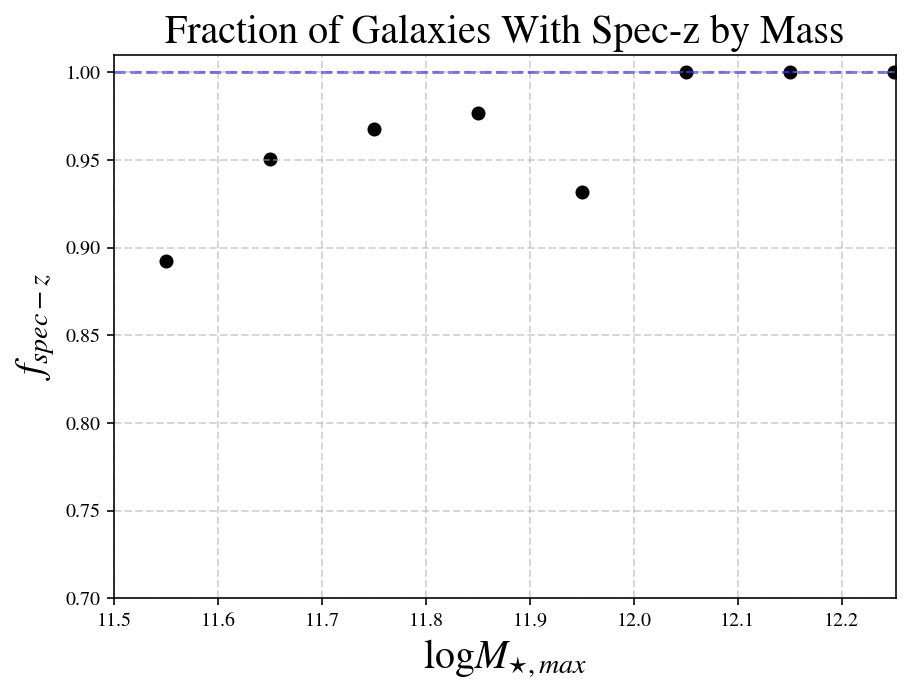

In [38]:
fig = plt.figure(figsize = [7,5])

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)
ax1.plot([np.min(pdr_mass_cut['logm_max']), np.max(pdr_mass_cut['logm_max'])], 
         [1.0,1.0], color = 'blue', ls = '--', alpha = 0.5)
ax1.scatter(bin_centers, frac_specz, color = 'k')
ax1.set_ylim(0.7,1.01)
ax1.set_xlim(np.min(pdr_mass_cut['logm_max']), np.max(pdr_mass_cut['logm_max']))
ax1.set_xlabel('$\log M_{\star, max}$', fontsize = 20)
ax1.set_ylabel('$f_{spec-z}$', fontsize = 20)
ax1.set_title('Fraction of Galaxies With Spec-z by Mass', fontsize = 20)

plt.savefig('specz_frac.eps', dpi = 1000)

### The next order of business here is to find close photo-z pairs. To do this, I'm going to modify my satellite finding code below

In [24]:
# set cosmology params
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params)
cosmology.setCosmology('huang18')
from colossus.halo import mass_so

# Now to find r_halo
r_halo = mass_so.M_to_R((10**pdr_mass_cut['logmh_vir'])*h , pdr_mass_cut['z_best'], '200m')/h # kpc

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(pdr_mass_cut['z_best'])
r_halo_deg = ((r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

# put the array data into a new table
pdr_mass_cut['r_halo'] = r_halo_deg
pdr_mass_cut.sort('logm_max')

# bins before reversing table
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]
pdr_mass_cut.reverse() # rank order by mass

In [25]:
# redo the isnan
pdr_mass_cut['missing_specz'] = np.isnan(pdr_mass_cut['z_spec'])
print(pdr_mass_cut['missing_specz'])

missing_specz
-------------
        False
        False
        False
        False
        False
        False
        False
        False
        False
        False
          ...
        False
         True
        False
        False
        False
        False
         True
        False
        False
        False
         True
Length = 2405 rows


In [78]:
# ---------- PDR Functions ---------------------

def pdr_pair(i, table, z_lim):
   
    # the object we choose here is going to be a central by the way we have defined things
    cent_gal = table[i] 
    
    # this was a trick that song used to make a new catalog for the other objects of interest.
    # the utility is that we don't have to loop through the whole catalog EVERY TIME
    cat_use = copy.deepcopy(table[(table['logm_max'] < cent_gal['logm_max'])])
    
    
    # find the galaxies within the delta z limit
    dz= cat_use[np.abs(cent_gal['z_best'] - cat_use['z_best']) <= z_lim]
    
    if len(dz) > 0:
        # find separation for gals within dz
        dz['sep'] = cent_gal['coord'].separation(dz['coord']).degree 
    for i in range(len(dz)):
        if dz['sep'][i] <= cent_gal['r_halo']:
            table['pair'][int(dz['index'][i])] = 1
            table['pair'][int(cent_gal['index'])] = 1
            #table['flag'][int(cent_gal['index'])] = 1
        
        if dz['sep'][i] <= cent_gal['r_halo'] and dz['missing_specz'][i] == True and cent_gal['missing_specz'] == True:
            table['flag'][int(dz['index'][i])] = 1
            table['flag'][int(cent_gal['index'])] = 1
            
            
            
        if dz['sep'][i] <= cent_gal['r_halo'] and dz['missing_specz'][i] == False and cent_gal['missing_specz'] == True:
            #table['flag'][int(dz['index'][i])] = 2
            table['flag'][int(cent_gal['index'])] = 2
            
        if dz['sep'][i] <= cent_gal['r_halo'] and dz['missing_specz'][i] == True and cent_gal['missing_specz'] == False:
            table['flag'][int(dz['index'][i])] = 2
            #table['flag'][int(cent_gal['index'])] = 2
            

def run_pdr_pair(in_table, dz, bin_edges):

    in_table['coord'] = SkyCoord(in_table['ra']*u.deg, in_table['dec']*u.deg) # angular coordinate of each galaxy

    in_table['flag'] = np.zeros(len(in_table['logm_max']))
    
    in_table['pair'] = np.zeros(len(in_table['logm_max']))

    in_table['index'] = np.zeros(len(in_table['logm_max']))
    for i in range(len(in_table['index'])):
        in_table['index'][i] = i
        in_table['sep'] = np.zeros(len(in_table['logm_max'])) #column of angular separations

    for idx in range(len(in_table)):
        pdr_pair(idx, in_table, dz)
    
    in_table.remove_columns(['sep','coord'])

    pair_table = Table(names = in_table.colnames)
    one_each_table = Table(names = in_table.colnames)
    phot_table = Table(names = in_table.colnames)

    for i in range(len(in_table['flag'])):
        if in_table['pair'][i] == 1:
            pair_table.add_row(in_table[i])
        if in_table['flag'][i] == 1:
            phot_table.add_row(in_table[i])
        if in_table['flag'][i] == 2:
            one_each_table.add_row(in_table[i])

    hist_pair, edges_pair = np.histogram(pair_table['logm_max'], bins = bin_edges)
    hist_phot, edges_phot = np.histogram(phot_table['logm_max'], bins = bin_edges)
    hist_one_each, edges_one_each = np.histogram(one_each_table['logm_max'], bins = bin_edges)


    mass_center = np.log10((10**(edges_pair[1:]) + 10**(edges_pair[:-1])) / 2)


    return(mass_center, hist_pair, hist_one_each, hist_phot)


In [79]:
mass_center, pairs, one_phot, phot_pair = run_pdr_pair(pdr_mass_cut, .03, mass_bins)

In [80]:
pairs

array([197, 120,  74,  38,  14,   6,   2,   0])

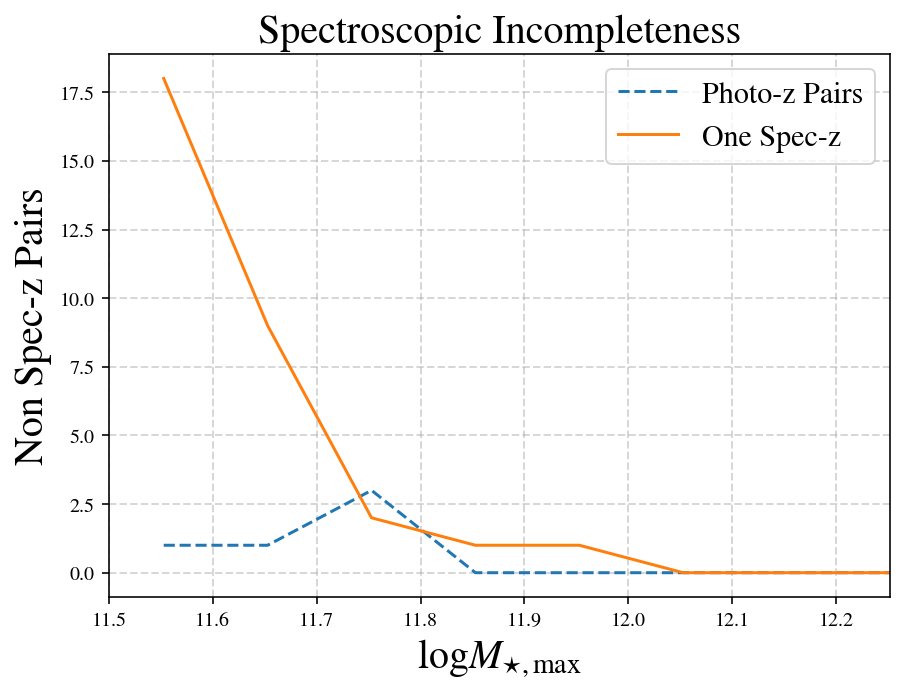

In [48]:
fig = plt.figure(figsize = [7,5])

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)
ax1.plot(mass_center, phot_pair, ls = '--', label = 'Photo-z Pairs')
ax1.plot(mass_center, one_phot, label = 'One Spec-z')
ax1.set_xlim(np.min(pdr_mass_cut['logm_max']), np.max(pdr_mass_cut['logm_max']))
ax1.set_xlabel('$\log M_{\star, \mathrm{max}}$', fontsize = 20)
ax1.set_ylabel('Non Spec-z Pairs', fontsize = 20)
ax1.set_title('Spectroscopic Incompleteness', fontsize = 20)
ax1.legend(fontsize = 15)

#plt.savefig('specz_frac.eps', dpi = 1000)

In [69]:
pair_frac = (one_phot + phot_pair) / pairs
for i in range(len(pair_frac)):
    if np.isnan(pair_frac[i]) == True:
        pair_frac[i] = 0
    if pair_frac[i] > 1:
        pair_frac[i] = 0
pair_frac

/Users/astro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/astro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.        , 0.32258065, 0.04464286, 0.01449275, 0.04347826,
       0.        , 0.        , 0.        ])

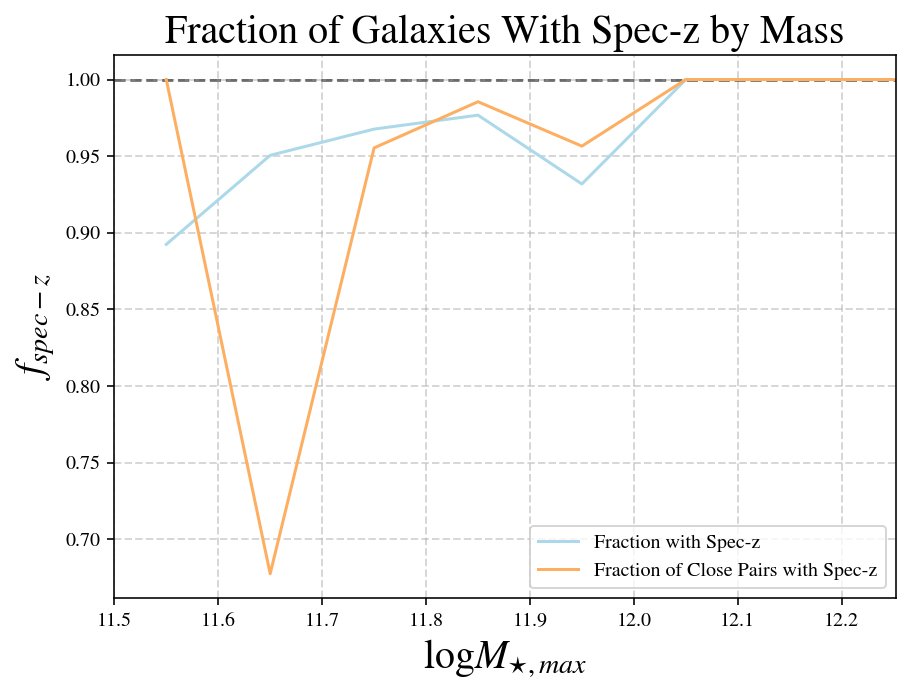

In [88]:
fig = plt.figure(figsize = [7,5])

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)
ax1.plot([np.min(pdr_mass_cut['logm_max']), np.max(pdr_mass_cut['logm_max'])], 
         [1.0,1.0], color = 'k', ls = '--', alpha = 0.5)
ax1.plot(bin_centers, frac_specz, color = '#abd9e9', label = 'Fraction with Spec-z')
ax1.plot(bin_centers, 1-pair_frac, color = '#fdae61', label ='Fraction of Close Pairs with Spec-z')

#ax1.set_ylim(0.7,1.01)
ax1.set_xlim(np.min(pdr_mass_cut['logm_max']), np.max(pdr_mass_cut['logm_max']))
ax1.set_xlabel('$\log M_{\star, max}$', fontsize = 20)
ax1.set_ylabel('$f_{spec-z}$', fontsize = 20)
ax1.set_title('Fraction of Galaxies With Spec-z by Mass', fontsize = 20)

ax1.legend()

